<a href="https://colab.research.google.com/github/bartleyn/practice/blob/master/Scaling_TablePipelines.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Running Tabular QA Transformer Pipelines

This is a notebook tutorial for how to run the Tabular Question Answering pipeline module in the Huggingface Transformers python library. 

There are roughly three types of tabular QA models available pre-trained:


1.  **Conversational** (e.g., SQA). This is useful for use-cases where you want to issue follow-up queries in a conversational manner.
2.  **Weakly supervised** for aggregation (e.g., WTQ). This is useful if you want the model to have learned the appropriate aggregation label (SUM/COUNT/AVERAGE/NONE) without ground-truth labels in the training data.
3.  **Strongly supervised** for aggregation (e.g., WikiSQL-supervised). This is useful if you want the model to have been trained with ground-truth aggregation operators alongside the training data.

### What is TaPas?

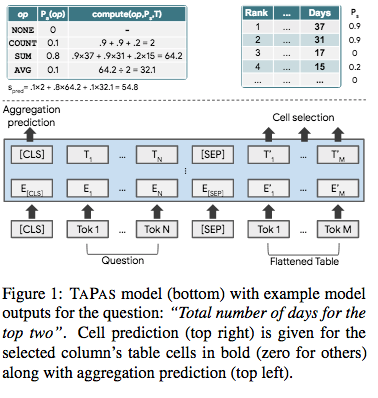


The TaPas model is inspired by the BERT transformer, which structures each training instance as a sequence of word tokens. While pre-training the model, the model will flatten the table and training query and tokenize the text into word pieces, as described into Figure 1. The model will then mask random tokens from the example and will try to learn to predict what the missing tokens are. There are two classifiers that are also trained simultaneously: 

1. Predicting what the aggregation operator is.
2. Predicting what cell(s) should be selected for the answer to the query.


[Here's the TaPas paper you can read for additional context.](https://www.aclweb.org/anthology/2020.acl-main.398.pdf)

## 1. Installation

In [17]:
!pip install transformers
!pip install sentencepiece
!pip install pandas
!pip install torch-scatter

## 2. Imports

In [18]:
from transformers import AutoTokenizer, pipeline, AutoModelForTableQuestionAnswering
import pandas as pd

## 3. Loading Tokenizer & Model

If you want to make use of the different pre-trained models on huggingface, check out one of the various models [here](https://huggingface.co/models?filter=table-question-answering). When you go to an individual model card, click on "Use in Transformers":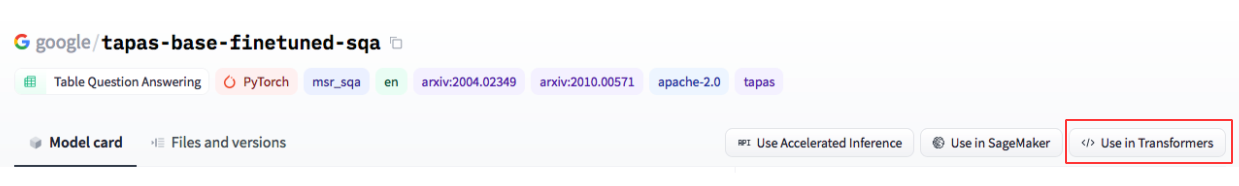

You will see example code you can use to load the model's tokenizer & model, and information about cloning it from the repo directly if you want to:

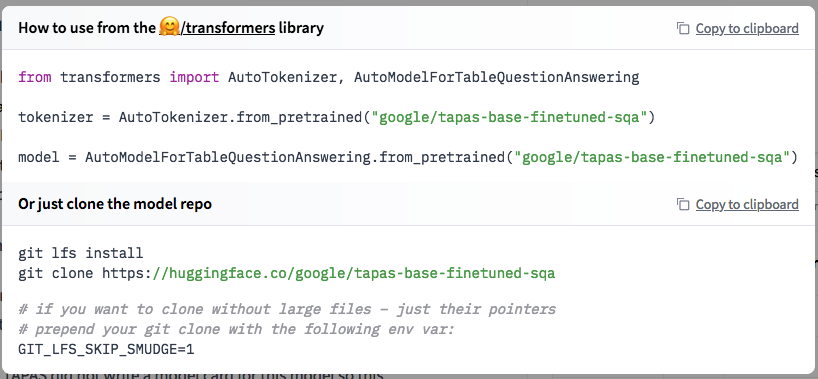

In [19]:
#tokenizer = AutoTokenizer.from_pretrained("google/tapas-base-finetuned-sqa")
tokenizer = AutoTokenizer.from_pretrained("google/tapas-base-finetuned-wtq")

In [20]:
#model = AutoModelForTableQuestionAnswering.from_pretrained("google/tapas-base-finetuned-sqa")
model = AutoModelForTableQuestionAnswering.from_pretrained("google/tapas-base-finetuned-wtq")

## 4. Creating Pipeline for QA

In [27]:
nlp = pipeline('table-question-answering', 
               model=model,
               tokenizer=tokenizer,
               )

## 5. Using Pre-trained Pipeline on data

You can specify your input tabular data as either a ```dict``` or a ```pd.DataFrame```.

In [6]:
table_data_movies = pd.DataFrame.from_dict({
    "actors": ["brad pitt", "leonardo di caprio", "george clooney"],
    "age": ["56", "45", "59"],
    "number of movies": ["87", "53", "69"],
    "date of birth": ["7 february 1967", "10 june 1996", "28 november 1967"],
})

table_data_grades = {
    "student": ["nathan", "alex", "lauren", "adrienne"],
    "grade": ["83", "88", "93", "87"],
    "final exam score": ["90", "91", "94", "96"],
}

You can specify queries as either:
*  a ```str``` 
*  or a ```List(str)```



In [7]:
query_movies = "How many movies was Leonardo Di Caprio in?"
query_movies = ["When was Brad Pitt born?", "How old is George Clooney?"]

query_grades = "What was Nathan's final exam score?"
query_avg = "What was the average final exam score?"

Finally, you can issue those queries on your tabular data in a variety of different formats:


*   ```pipeline(table, query)```
*   ```pipeline(table, [query])```
*   ```pipeline(table=table, query=query)```
*   ```pipeline(table=table, query=[query])```
*   ```pipeline({'table':table, 'query':query})```
*   ```pipeline({'table':table, 'query':[query]})```
*   ```pipeline([{'table':table, 'query':query}, {'table': table, 'query', query}])```





In [8]:
nlp(table=table_data_movies, query=query_movies)

[{'aggregator': 'NONE',
  'answer': '7 february 1967',
  'cells': ['7 february 1967'],
  'coordinates': [(0, 3)]},
 {'aggregator': 'AVERAGE',
  'answer': 'AVERAGE > 59',
  'cells': ['59'],
  'coordinates': [(2, 1)]}]

In [9]:
nlp([{"table": table_data_movies, "query": query_movies}, 
    {"table": table_data_grades, "query": query_grades}])

[[{'aggregator': 'NONE',
   'answer': '7 february 1967',
   'cells': ['7 february 1967'],
   'coordinates': [(0, 3)]},
  {'aggregator': 'AVERAGE',
   'answer': 'AVERAGE > 59',
   'cells': ['59'],
   'coordinates': [(2, 1)]}],
 {'aggregator': 'AVERAGE',
  'answer': 'AVERAGE > 90',
  'cells': ['90'],
  'coordinates': [(0, 2)]}]

In [10]:
nlp(table_data_grades, query_avg)

{'aggregator': 'AVERAGE',
 'answer': 'AVERAGE > 90, 91, 94, 96',
 'cells': ['90', '91', '94', '96'],
 'coordinates': [(0, 2), (1, 2), (2, 2), (3, 2)]}

Each result is a ```dict``` with the following keys:

*   **answer** - a ```str```. If an aggregator is available, will be prefaced by ```AGGREGATOR >```
*   **coordinates** - a ```List(Tuple(int,int))``` containing the coordinates of the answer (example index, field index)
*   **cells** - a ```List(str)``` containing the answer cell values
*   **aggregator** - a ```str``` if the model uses an aggregator

## 6. Aggregator

For models with an aggregation head (e.g., TAPAS pre-trained on WTQ), you may access the kind of aggregation the model predicts for your query. For example, if your query is "What is the average number of movies for each actor?" You may get the following result: 

```AVERAGE > "87", "53", "69"```


Below we run the above cells but use the ```"google/tapas-base-finetuned-wtq"``` model and tokenizer.

In [11]:

'''Code adapted from https://huggingface.co/transformers/model_doc/tapas.html#usage-inference
'''

inputs = tokenizer(table=pd.DataFrame(table_data_grades), queries=query_avg, 
                   padding='max_length', return_tensors="pt")
outputs = model(**inputs)
#print(outputs)
predicted_answer_coordinates, predicted_aggregation_indices = tokenizer.convert_logits_to_predictions(
         inputs,
         outputs.logits.detach(),
         outputs.logits_aggregation.detach()
 )

# let's print out the results:
id2aggregation = {0: "NONE", 1: "SUM", 2: "AVERAGE", 3:"COUNT"}
aggregation_predictions_string = [id2aggregation[x] for x in predicted_aggregation_indices]

answers = []
for coordinates in predicted_answer_coordinates:
   if len(coordinates) == 1:
     # only a single cell:
     answers.append(table.iat[coordinates[0]])
   else:
     # multiple cells
     cell_values = []
     for coordinate in coordinates:
        cell_values.append(pd.DataFrame(table_data_grades).iat[coordinate])
     answers.append(", ".join(cell_values))

display(table_data_grades)
print("")
for query, answer, predicted_agg in zip([query_avg], answers, aggregation_predictions_string):
  print(query)
  if predicted_agg == "NONE":
    print("Predicted answer: " + answer)
  else:
    print("Predicted answer: " + predicted_agg + " > " + answer)

{'final exam score': ['90', '91', '94', '96'],
 'grade': ['83', '88', '93', '87'],
 'student': ['nathan', 'alex', 'lauren', 'adrienne']}


What was the average final exam score?
Predicted answer: AVERAGE > 90, 91, 94, 96


## 7. Scaling tests

In [12]:
!wget https://www.bls.gov/iif/oshwc/osh/os/summ1_00_2019.xlsx

--2021-06-14 20:33:08--  https://www.bls.gov/iif/oshwc/osh/os/summ1_00_2019.xlsx
Resolving www.bls.gov (www.bls.gov)... 23.62.77.125, 2600:1405:800:19d::18b9, 2600:1405:800:195::18b9
Connecting to www.bls.gov (www.bls.gov)|23.62.77.125|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 82128 (80K) [application/vnd.openxmlformats-officedocument.spreadsheetml.sheet]
Saving to: ‘summ1_00_2019.xlsx.1’

summ1_00_2019.xlsx. 100%[===================>]  80.20K  --.-KB/s    in 0.02s   

2021-06-14 20:33:09 (5.21 MB/s) - ‘summ1_00_2019.xlsx.1’ saved [82128/82128]



In [13]:
pd.read_excel('summ1_00_2019.xlsx', header=[2,3]) # header specifies the levels for the multi-index over the column names

Industry(2)  ... Other recordable cases
                                     Unnamed: 0_level_1  ...     Unnamed: 7_level_1
0     All industries including private, state and lo...  ...                    NaN
1                                   Private industry(5)  ...                    NaN
2                                    Goods-producing(5)  ...                    NaN
3                    Natural resources and mining(5)(6)  ...                    NaN
4         Agriculture, forestry, fishing and hunting(5)  ...                    NaN
...                                                 ...  ...                    ...
1082  (9) Data for mining operators in this industry...  ...                    NaN
1083  (10) Data for employers in rail transportation...  ...                    NaN
1084                          (11) Rate rounded to zero  ...                    NaN
1085  Note: Because of rounding, components may not ...  ...                    NaN
1086  Source: Bureau of Labor Statistics, U.S. Depar...  ...                    NaN

[1087 rows x 8 columns]

In [21]:
input_df = pd.read_excel('summ1_00_2019.xlsx', header=[2,3]).drop([1072, 1073, 1074, 1075, 1076, 1077, 1078, 1079, 1080, 1081, 1082, 1083, 1084, 1085, 1086]).fillna("-1").astype('string')
# We drop a bunch of rows at the end that are footnotes and convert all inputs into strings

In [22]:
input_df.columns = [' '.join(col).strip() for col in input_df.columns.values] # We flatten the multi-index over the columns to one level

In [ ]:
input_df.shape[0]

1072

In [23]:
query_cases = "What is the cases with days away from work for metal ore mining?"
query_cases = ["What is the total recordable cases for private industry?", "What is the total recordable cases for oilseed farming?"]

table = input_df.iloc[:30,:].astype('object') # Choosing 30 rows due to RAM constraints

In [24]:
inputs = tokenizer(table=table, queries=query_cases, padding='max_length', return_tensors="pt", max_row_id=64, max_length=1357)#, max_length=2050)

In [21]:
model(**inputs)

TableQuestionAnsweringOutput([('logits',
                               tensor([[-10017.5879, -10017.5879, -10017.5879,  ..., -10017.5879,
                                        -10017.5879, -10017.5879],
                                       [-10019.0303, -10019.0303, -10019.0303,  ..., -10019.0303,
                                        -10019.0303, -10019.0303]], grad_fn=<ViewBackward>)),
                              ('logits_aggregation',
                               tensor([[ -1.9391, -10.1531,  17.2712, -17.3348],
                                       [ -2.8832,  -3.9953,  17.3558, -15.0133]], grad_fn=<AddmmBackward>))])

In [25]:
outputs = model(**inputs)

In [26]:

predicted_answer_coordinates, predicted_aggregation_indices = tokenizer.convert_logits_to_predictions(
         inputs,
         outputs.logits.detach(),
         outputs.logits_aggregation.detach()
 )

# let's print out the results:
id2aggregation = {0: "NONE", 1: "SUM", 2: "AVERAGE", 3:"COUNT"}
aggregation_predictions_string = [id2aggregation[x] for x in predicted_aggregation_indices]

answers = []
for coordinates in predicted_answer_coordinates:
   if len(coordinates) == 1:
     # only a single cell:
     answers.append(table.iat[coordinates[0]])
   else:
     # multiple cells
     cell_values = []
     for coordinate in coordinates:
        cell_values.append(table.iat[coordinate])
     answers.append(", ".join(cell_values))

print("")
for query, answer, predicted_agg in zip(query_cases, answers, aggregation_predictions_string):
  print(query)
  if predicted_agg == "NONE":
    print("Predicted answer: " + answer)
  else:
    print("Predicted answer: " + predicted_agg + " > " + answer)


What is the total recordable cases for private industry?
Predicted answer: AVERAGE > 2.8
What is the total recordable cases for oilseed farming?
Predicted answer: AVERAGE > 5.7


In [28]:
input_df.iloc[:30]

,Industry(2) Unnamed: 0_level_1,NAICS code(3) Unnamed: 1_level_1,Total recordable cases Unnamed: 2_level_1,"Cases with days away from work, job restriction, or transfer Total","Cases with days away from work, job restriction, or transfer Cases with days away from work(4)","Cases with days away from work, job restriction, or transfer Cases with days of job transfer or restriction",Other recordable cases Unnamed: 6_level_1,Other recordable cases Unnamed: 7_level_1
0,"All industries including private, state and lo...",-1,3,1.6,0.9,0.7,1.4,-1
1,Private industry(5),-1,2.8,1.5,0.9,0.7,1.2,-1
2,Goods-producing(5),-1,3.1,1.9,1,0.9,1.2,-1
3,Natural resources and mining(5)(6),-1,3.4,2.1,1.2,0.9,1.3,-1
4,"Agriculture, forestry, fishing and hunting(5)",11,5.2,3.2,1.7,1.5,2,-1
5,Crop production(5),111,5.3,3.1,1.4,1.6,2.2,-1
6,Oilseed and grain farming(5),1111,5.7,2.6,1.2,1.4,3.1,-1
7,Vegetable and melon farming(5),1112,4.9,2.6,1.3,1.4,2.2,-1
8,Fruit and tree nut farming(5),1113,5.9,3.7,1.7,1.9,2.3,-1
9,"Greenhouse, nursery, and floriculture producti...",1114,5.1,2.9,1.2,1.7,2.2,-1


## 8. Examples of queries

In [30]:
nlp(table=input_df.iloc[:30,:].astype('object'), \
    query="What is the cases with days away from work for hog and pig farming?", padding='max_length')

{'aggregator': 'AVERAGE',
 'answer': 'AVERAGE > 1.9',
 'cells': ['1.9'],
 'coordinates': [(15, 4)]}

In [33]:
nlp(table=input_df.iloc[:30,:].astype('object'), \
    query="What is the industry with the highest total number of cases with days away from work?", padding='max_length')

{'aggregator': 'NONE',
 'answer': 'Cotton ginning',
 'cells': ['Cotton ginning'],
 'coordinates': [(26, 0)]}

In [34]:
nlp(table=input_df.iloc[:30,:].astype('object'), \
    query="What is the industry with the lowest total number of cases with days away from work?", padding='max_length')

{'aggregator': 'NONE',
 'answer': 'All industries including private, state and local government(5)',
 'cells': ['All industries including private, state and local government(5)'],
 'coordinates': [(0, 0)]}

In [37]:
nlp(table=input_df.iloc[:30,:].astype('object'), \
    query="What is the number of industries with other recordable number of cases greater than or equal to 2?", padding='max_length')

{'aggregator': 'COUNT',
 'answer': 'COUNT > Agriculture, forestry, fishing and hunting(5), Crop production(5), Oilseed and grain farming(5), Vegetable and melon farming(5), Fruit and tree nut farming(5), Greenhouse, nursery, and floriculture production(5), Animal production and aquaculture(5), Beef cattle ranching and farming, including feedlots(5), Hog and pig farming(5), Other animal production(5), Soil preparation, planting, and cultivating, Crop harvesting, primarily by machine, Farm labor contractors and crew leaders',
 'cells': ['Agriculture, forestry, fishing and hunting(5)',
  'Crop production(5)',
  'Oilseed and grain farming(5)',
  'Vegetable and melon farming(5)',
  'Fruit and tree nut farming(5)',
  'Greenhouse, nursery, and floriculture production(5)',
  'Animal production and aquaculture(5)',
  'Beef cattle ranching and farming, including feedlots(5)',
  'Hog and pig farming(5)',
  'Other animal production(5)',
  'Soil preparation, planting, and cultivating',
  'Crop harv

## 9. Practical concerns

In the TaPas paper, the authors specify that there are scalability concerns in using the model. There are three parameters that can be specified with regards to the input table you want to extract information from:

  * **Maximum number of rows**. The huggingface transformers models will have specified the maximum number of rows that input tables can have in the model's config.json. Here is the ```tapas-base-finetuned-wtq``` [config.json](https://huggingface.co/google/tapas-base-finetuned-wtq/blob/main/config.json).
  * **Maximum number of columns**. Similar to the rows, the config.json file specifies  maximum number of columns as well.
  * **Max sequence length**. Given that the TaPas model flattens the question and table into a single sequence of tokens, it has trouble scaling as well. The tokenizer has a ```max_length``` parameter that will throw an error if your input table and query has a row that is too long for input.


Other concerns / future work include:
  * **Complex column headers**. Like in the presented example, you may have complex column headers. It would be beneficial to flatten a column multiindex to one level, choosing an appropriate column name for the single-level columns that do not have multiple levels.
  * **Compositional queries**. The model does not seem to work well with queries that are structured like "number of actors with an average rating higher than 4"
  * **Table compression**. Possibly compressing information in tables to minimize memory footprint of the training/inference tables.
